<a href="https://colab.research.google.com/github/neerajguleria1/driver-drowsiness-detection/blob/main/Untitled21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from google.colab import files
#uploaded=files.upload()

from cognitive_engine import CognitiveRiskEngine
from temporal_risk import TemporalRiskTracker
from decision_engine import DecisionEngine
from explainability import ExplainabilityEngine
pipelines=joblib.load("final_driver_drowsiness_pipeline.pkl")




Step 1
Risk: 3
State: SAFE | Trend: INSUFFICIENT_DATA
Decision: Continue driving
Why: [{'feature': 'System', 'value': 'Stable', 'threshold': 'N/A', 'severity': 'LOW', 'reason': 'No abnormal driver behavior detected'}]

Step 2
Risk: 5
State: SAFE | Trend: INSUFFICIENT_DATA
Decision: Continue driving
Why: [{'feature': 'System', 'value': 'Stable', 'threshold': 'N/A', 'severity': 'LOW', 'reason': 'No abnormal driver behavior detected'}]

Step 3
Risk: 8
State: SAFE | Trend: RISING
Decision: Monitor closely
Why: [{'feature': 'RiskTrend', 'value': 'RISING', 'threshold': 'RISING', 'severity': 'HIGH', 'reason': 'Risk score has been consistently increasing over time'}]

Step 4
Risk: 13
State: SAFE | Trend: RISING
Decision: Monitor closely
Why: [{'feature': 'RiskTrend', 'value': 'RISING', 'threshold': 'RISING', 'severity': 'HIGH', 'reason': 'Risk score has been consistently increasing over time'}]

Step 5
Risk: 20
State: SAFE | Trend: RISING
Decision: Monitor closely
Why: [{'feature': 'Fatigue',

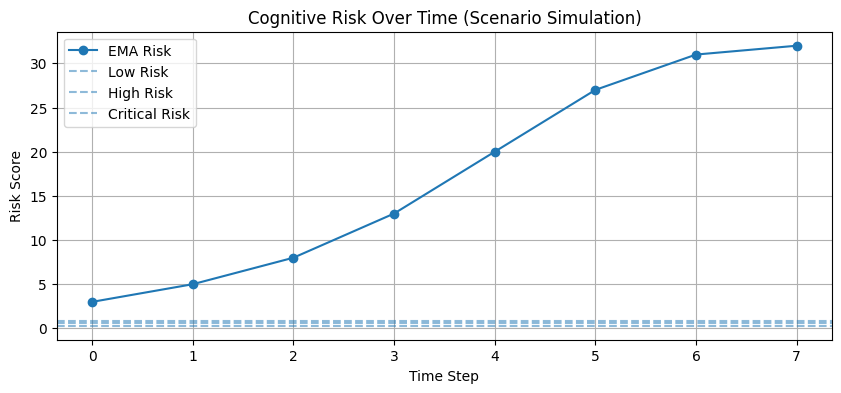

In [12]:
scenario = [
    {"Speed": 85, "Alertness": 0.9, "Heart_rate": 78, "Fatigue": 1},
    {"Speed": 80, "Alertness": 0.8, "Heart_rate": 85, "Fatigue": 3},
    {"Speed": 75, "Alertness": 0.7, "Heart_rate": 92, "Fatigue": 4},
    {"Speed": 70, "Alertness": 0.6, "Heart_rate": 98, "Fatigue": 6},
    {"Speed": 65, "Alertness": 0.5, "Heart_rate": 105, "Fatigue": 7},
    {"Speed": 60, "Alertness": 0.42, "Heart_rate": 112, "Fatigue": 8},
    {"Speed": 65, "Alertness": 0.6, "Heart_rate": 90, "Fatigue": 4},
    {"Speed": 70, "Alertness": 0.75, "Heart_rate": 82, "Fatigue": 2},
]

cognitive = CognitiveRiskEngine()
temporal = TemporalRiskTracker()
decision_engine = DecisionEngine()
explain_engine = ExplainabilityEngine()

risk_scores = []
states = []
logs = []

prev_alertness = None
prev_speed = None

for i, step in enumerate(scenario):

    current_alertness = step["Alertness"]
    current_speed = step["Speed"]

    # first step has no history
    if prev_alertness is None:
        step["prev_alertness"] = current_alertness
        step["speed_change"] = 0
    else:
        step["prev_alertness"] = prev_alertness
        step["speed_change"] = current_speed - prev_speed

    df = pd.DataFrame([step])

    # fake ML probability (higher fatigue → higher risk)
    ml_prob = min(1.0, 0.1 + step["Fatigue"] * 0.1)

    # instant cognitive risk
    cog = cognitive.compute(df, ml_prob)

    # temporal smoothing + trend detection
    temp = temporal.update(cog["risk_score"])

    # decision making
    decision = decision_engine.decide(
        temp["stable_state"],
        temp["trend"],
        temp["ema_risk"]
    )

    # explanation
    explanation = explain_engine.explain(df, temp)

    # store outputs
    risk_scores.append(temp["ema_risk"])
    states.append(temp["stable_state"])
    logs.append({
        "time": i,
        "ema_risk": temp["ema_risk"],
        "state": temp["stable_state"],
        "trend": temp["trend"],
        "decision": decision["action"]
    })

    # print results
    print(f"\nStep {i+1}")
    print("Risk:", round(temp["ema_risk"], 3))
    print("State:", temp["stable_state"], "| Trend:", temp["trend"])
    print("Decision:", decision["action"])
    print("Why:", explanation)

    # update memory
    prev_alertness = current_alertness
    prev_speed = current_speed

df_logs = pd.DataFrame(logs)
df_logs

plt.figure(figsize=(10,4))
plt.plot(risk_scores, marker="o", label="EMA Risk")

plt.axhline(0.3, linestyle="--", alpha=0.5, label="Low Risk")
plt.axhline(0.6, linestyle="--", alpha=0.5, label="High Risk")
plt.axhline(0.8, linestyle="--", alpha=0.5, label="Critical Risk")

plt.title("Cognitive Risk Over Time (Scenario Simulation)")
plt.xlabel("Time Step")
plt.ylabel("Risk Score")
plt.legend()
plt.grid(True)
plt.show()
